# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Вторая лабораторная работа </center>
# <center> Анализ сигналов </center>

In [1]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib

# Запретим numpy выполнять деление на 0
np.seterr(divide='raise', invalid='raise') 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Определим две функции для отрисовки сигнала. 
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveshow(wav, sr=sr)

def draw_sig(frames, name=None, figsize=(14, 3)):
    # Отрисовка сигнала в виде "леденцов на палочке"
    plt.figure(figsize=figsize)
    plt.stem(frames)
    if name is not None:
        plt.legend([name])
    plt.xlabel("n")
    plt.ylabel("Energy")
    plt.show()
    

Создадим несколько простых сигналов. Они нам понадобятся для дальшейшего тестирования

In [3]:
signals = {}

### Единичный импульс

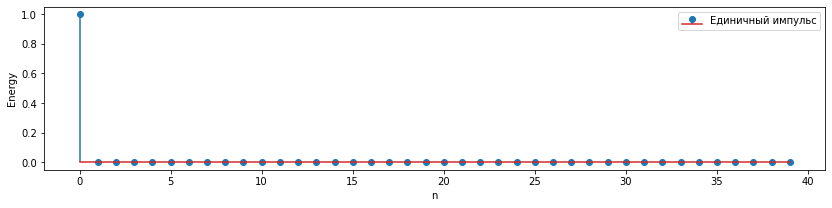

In [4]:
name = "Единичный импульс"
signals[name] = np.array([1] + [0]*39, dtype=float)
draw_sig(signals[name], name)

### Единичный скачок

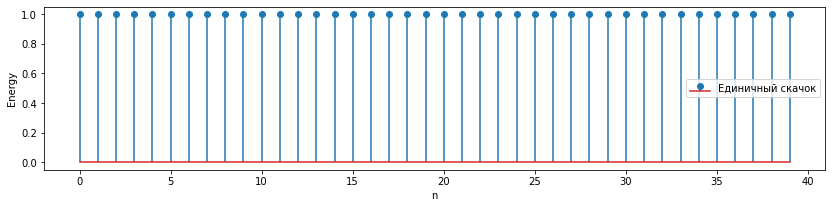

In [5]:
name = "Единичный скачок"
signals[name] = np.array([1]*40 ,dtype=float) 
draw_sig(signals[name], name)

### Синус

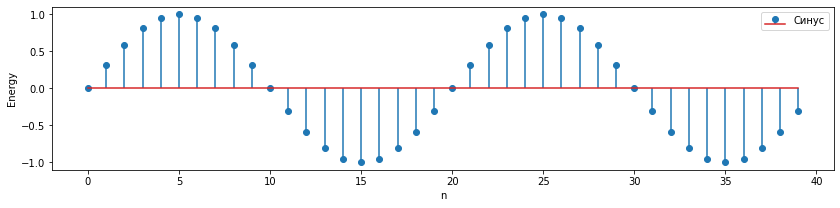

In [6]:
name = "Синус"
signals[name] = np.sin(np.pi * np.arange(40)/10)
draw_sig(signals[name], name)

### Шум

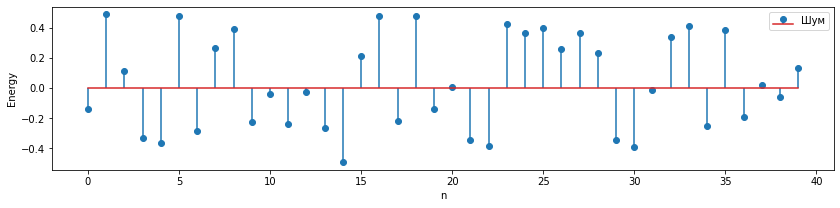

In [7]:
name = "Шум"
signals[name] = np.random.random(40)-0.5
draw_sig(signals[name], name)

-------------------------------
# Преобразование Фурье
Прежде, чем перейти к анализу сигналов, надо разобраться, что такое преобразование Фурье. 
> Преобразование Фурье (символ ℱ) — операция, сопоставляющая одной функции вещественной переменной другую функцию вещественной переменной. Эта новая функция описывает коэффициенты («амплитуды») при разложении исходной функции на элементарные составляющие — гармонические колебания с разными частотами (подобно тому, как музыкальный аккорд может быть выражен в виде суммы музыкальных звуков, которые его составляют). [Wiki](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A4%D1%83%D1%80%D1%8C%D0%B5)



Формула прямого дискретного преобразования Фурье (ДПФ, Discrete Fourier Transform, DFT):
$$ X_k = \sum_{n=0}^{N-1} x_{n} \cdot e^{-i \frac{2\pi}{N} k n} $$


# Задание 1 (2 балла)
Реализовать дискретное преобразование Фурье. Сравнить с реализацией *scipy.fft.fft*

In [8]:
def DFT(x):
    N = len(x)
    exp = [[np.exp(-1j * 2 * np.pi / N * k * n) for n in range(N)] for k in range(N)]
    res = np.array(exp) @ np.array(x)
    return res

Сравнение с библиотекой scipy

In [9]:
def test_DTF(x, transform=DFT):
    scipy_result = scipy.fft.fft(x)
    curr_result = transform(x)
    if scipy_result.shape != curr_result.shape:
        print("TEST_FAILED")
        print(f"Your spectrogram shape is {curr_result.shape}. "
              f"Scipy spectrogram shape is {scipy_result.shape}")
        return -1
    if not np.allclose(curr_result, scipy_result):
        print("TEST FAILED")
        print(f"scipy spectrogram: {scipy_result}")
        print(f"Your DTF spectrogram: {curr_result}")
        print(f"Average diff is {np.mean(np.abs(scipy_result - curr_result))}")
        return -2
    print("TEST PASSED")
    return 0

for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


Класическое ДПФ имеет существенный недостаток - сложность алгоритма $O(N^2)$. На данный момент существуют чуть более сложные реализации преобразования Фурье, которые избавляются от квадратичной сложности. Например, алгоритм быстрого преобразования Фурье (Fast Fourier Transform, FFT) имеет сложность $O(N log(N))$, что делает его значительно более быстрым на длинных последовательностях. 

# Задание 1.1* (1 балл)
Реализовать быстрое преобразование Фурье. Сравнить с scipy.fft.fft

**Подсказка:** учтите, что для БПФ нам нужно, чтобы количество отсчетов сигнала было степенью двойки

Реализуем алгоритм Кули - Тьюки

In [10]:
def sep(x):
    cur = 1
    for i in range(1, int(np.sqrt(x)) + 1):
        if x % i == 0:
            cur = i     
    return cur, int(x / cur)

def is_prime(x):
    for i in range(2, int(np.sqrt(x)) + 1):
        if x % i == 0:
            return False
    return True


In [11]:
def FFT(x):
    if len(x) <= 10 or is_prime(len(x)):
        return DFT(x)

    n = len(x)
    n1, n2 = sep(n)
    x = np.array([[x[n1 * k + i] for i in range(n1)] for k in range(n2)])
    y = np.array([FFT(x[:, i]) for i in range(n1)])
    exp = [[np.exp(-1j * 2 * np.pi / n * (k * i % n)) for i in range(n2)] for k in range(n1)]
    z = y * np.array(exp)
    res = np.array([FFT(z[:, i]) for i in range(n2)]).T.flatten()

    return res

In [12]:
for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig, transform=FFT) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


А теперь давайте посмотрим, насколько мы улучшили ДПФ

In [13]:
import timeit

In [14]:
def x(n):
    return [np.sin(i/2/np.pi) for i in range(n)]

In [15]:
t1 = []
for i in range(1, 10):
    start_time = timeit.default_timer()
    DFT(x(100*i))
    t1.append(timeit.default_timer() - start_time)

In [16]:
t2 = []
for i in range(1, 10):
    start_time = timeit.default_timer()
    FFT(x(100*i))
    t2.append(timeit.default_timer() - start_time)

In [17]:
t3 = []
for i in range(1, 10):
    start_time = timeit.default_timer()
    scipy.fft.fft(x(100*i))
    t3.append(timeit.default_timer() - start_time)

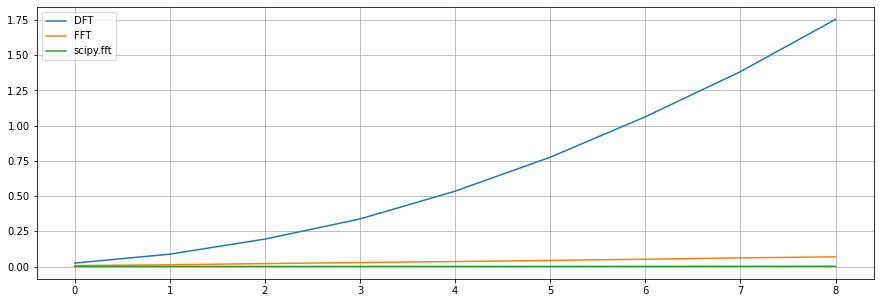

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(t1, label='DFT')
plt.plot(t2, label='FFT')
plt.plot(t3, label='scipy.fft')
plt.legend()
plt.grid()

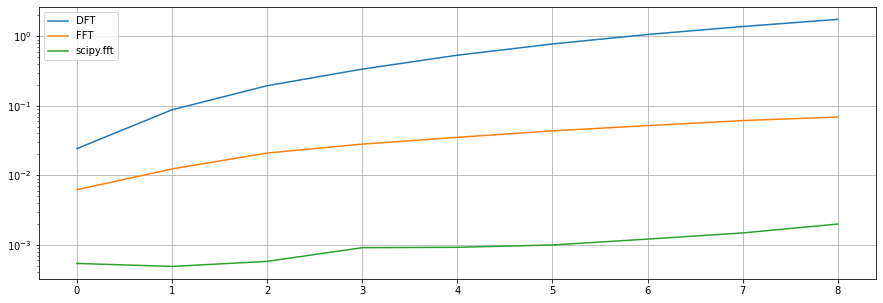

In [19]:
plt.figure(figsize=(15, 5))
plt.semilogy(t1, label='DFT')
plt.semilogy(t2, label='FFT')
plt.semilogy(t3, label='scipy.fft')
plt.legend()
plt.grid()

Если вы изменяли длительность исходных сигналов, не забудьте вернуть их изначальную длительность

In [20]:
# YOUR CODE HERE

# Амплитудный и фазовый спектры
Поскольку преобразование Фурье определено в комплекстной области, анализировать результат напрямую проблематично. Для анализа сигналов принято разбивать результат преобразования Фурье на два спектра: амплитудный и фазовый. Амплитудный показывает, как меняется модуль сигнала, а фазовый - как меняется угол, образуемый на комплексной плоскости. 
# Задание 2 (1 балл)

Реализовать функции построения амплитудного и фазового спектра

In [21]:
#функция построения амплитудного спектра
def get_amplitude_from_spec(spec):
    res = np.abs(spec)
    return res

#функция построения фазового спектра
def get_phi_from_spec(spec):
    res = np.arctan(spec.imag/(spec.real + 1e-6))
    return res

In [22]:
def check_mean_var(sig, mean=None, var=None):
    if mean is not None and np.mean(sig) != mean:
        print(f"Bad mean. Expected {mean}, got {np.mean(sig)}")
        return False
    if var is not None and np.var(sig) != var:
        print(f"Bad var. Expected {var}, got {np.var(sig)}")
        return False
    return True

_spec = scipy.fft.fft(np.array([1]+[0]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 0.0), \
    "Wrong Amplitude"
assert check_mean_var(get_phi_from_spec(_spec), 0.0, 0.0), \
    "Wrong Phase"

    
_spec = scipy.fft.fft(np.array([1]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 9.0), \
    "Wrong  Amplitude"
assert get_amplitude_from_spec(_spec)[0] == 10, \
    "Wrong Amplitude"
assert get_phi_from_spec(_spec)[0] == 0, \
    "Wrong phase"

_spec = scipy.fft.fft(scipy.fft.ifft(np.array([0] + [10+5j]+[0]*6 + [10-5j])))
assert get_amplitude_from_spec(_spec).round(1)[1] == 11.2 , \
    "Wrong Amplitude. Make sure it is a complex number module."
assert get_phi_from_spec(_spec).round(1)[1] == 0.5 , \
    "Wrong Amplitude. Make sure it is an angle."

   
print("All OK!")

All OK!


Определим еще одну функцию для отрисовки. Теперь будем рисовать сигнал в частотной области

In [23]:
def draw_spec(spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3)):
    if len(spec)<100:
        # Рисуем точки как "леденцы на палочках"
        draw_func = plt.stem
    else:
        # При большом N "леденцы" выглядят плохо, 
        # Поэтому будем рисовать огибающую функцию
        draw_func = plt.plot
    
    if draw_A:
        plt.figure(figsize=figsize)
        plt.title("Amplitude spectrum")
        spec_A = get_amplitude_from_spec(spec)
        draw_func(spec_A)
        plt.ylabel("Magnitude")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
        
    if draw_p:
        plt.figure(figsize=figsize)
        plt.title("Phase spectrum")
        phi = get_phi_from_spec(spec)
        draw_func(phi)
        plt.ylabel("Radian")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
    return 

# Задание 2.1 (0.5 балла)
Постройте спектры для всех сигналов из коллекции signals и ответьте на вопросы:
<!-- 1. Почему амплитуда всех гармоник единичного импульса равна единице? 
1. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый? 
1. Как перевести номер отсчета в частоту?  
1. Что в фазовом спектре является полезной информацией, а что - шумом? Почему? -->

### Визуализация:

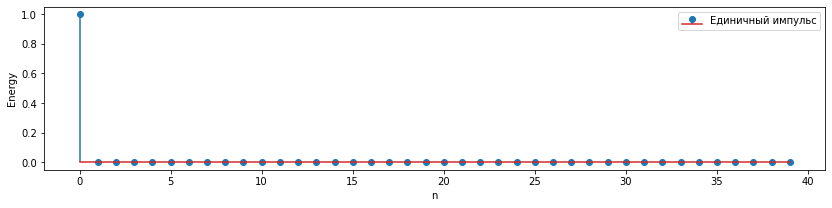

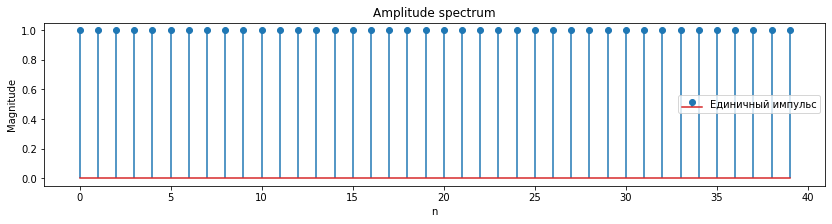

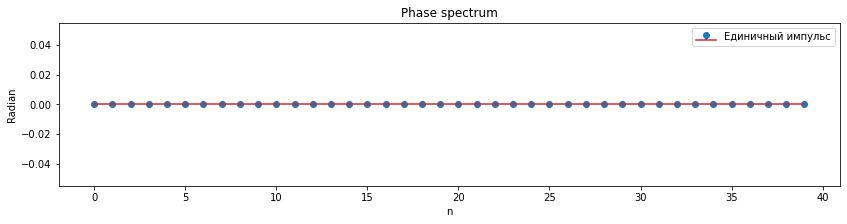

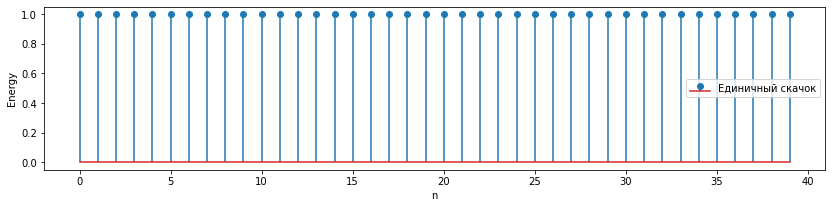

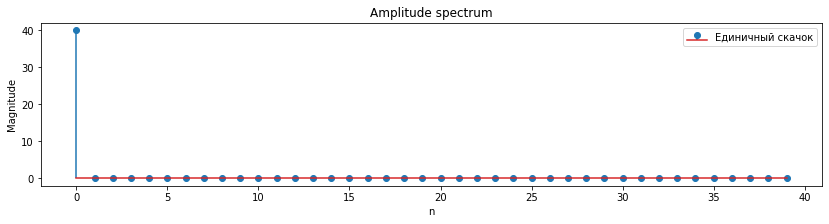

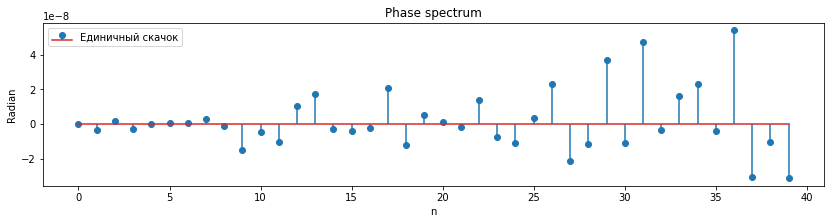

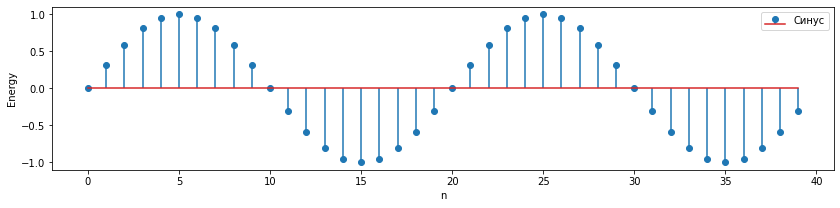

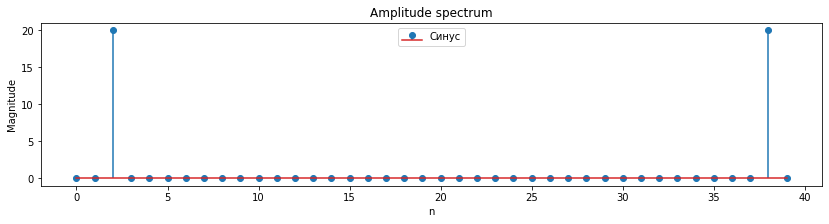

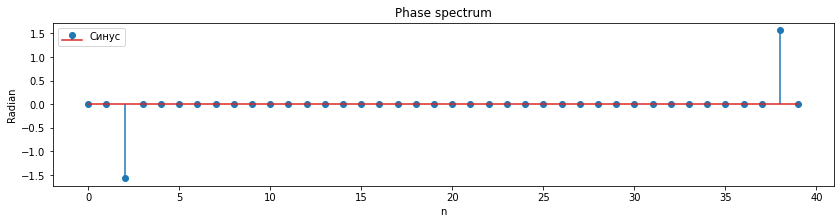

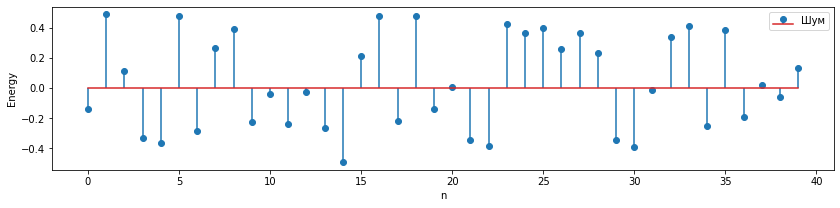

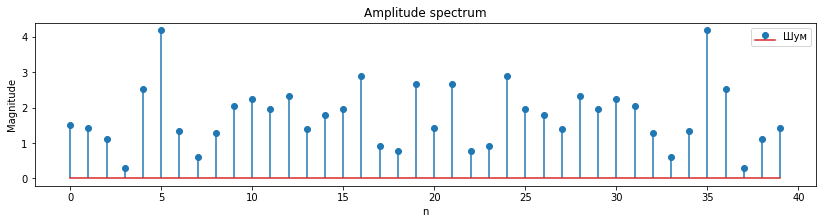

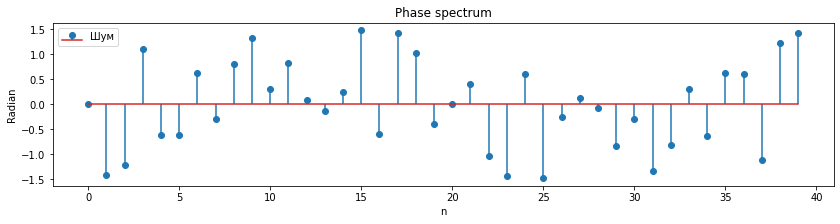

In [24]:
for name, signal in signals.items():
    spec = DFT(signal)
    draw_sig(signal, name)
    draw_spec(spec, name)

### 1.Почему амплитуда всех гармоник единичного импульса равна константе?

Если мы посмотрим на формулу разложения в ряд Фурье единичного импульса, то увидим, что для любых k значение коэффициента равно единице.

$$X(k) = \sum\limits_0^{N-1}\delta(n)e^{\frac{-2\pi i}{N} kn} =1$$

### 2. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый?

Из амплитудного спетра можно понять какие гармоники вносят наибольший вклад в сигнал, а из фазового с какой фазой эти гармоники входят в сигнал.

### 3. Как перевести номер отсчета в частоту?

Частота отсчета с номером $k$ выражается формулой $f_k = \frac{f_d}{N}k$, где $f_d$ -- это частота дискретизации.

### 4. Что в фазовом спектре является полезной информацией, а что - шумом? Почему?

Особенность фазового спектра заключается в том, что по нему нельзя определить какие частоты являются шумом, а какие сигналом. Поэтому для извлечения полезной информации нужно сперва посмотреть на амплитудный спектр, понять какие частоты нас интересуют, а потом уже смотреть на их фазу на фазовом спектре.

# Оконное преобразование Фурье
Преобразование Фурье делает переход из временной области в частотную, позволяя анализировать составляющие сигнал гармоники. Однако это не всегда удобно. В реальных сигналах зачастую составляющие их гармоники изменяются со временем. Например, каждая буква в слове имеет свой набор основных гармоник, и простое преобразование Фурье не сильно поможет нам определить, что было сказано. Для того, чтобы анализировать такие сигналы, обычно используется [Оконное преобразование Фурье](https://ru.wikipedia.org/wiki/Оконное_преобразование_Фурье). Такое преобразование позволяет анализировать гармоники сигнала в коротких промежутках времени и сохранить временную ось при построении спектрограммы.
# Задание 3 (2 балла)
Реализовать оконное преобразование Фурье (Short-time Fourier transform), пользуясь только библиотеками *numpy* и *scipy*. Сравнить с *librosa.stft*


In [25]:
def STFT(x, n_fft=2048, hop_length=512, window='hann'):
    # x - signal
    # n_fft - fft window size 
    # hop_length - step size between ffts
    # window - window type. See scipy.signal.get_window
    # return spectrogram
    n = len(x)
    x = [0]*(n_fft // 2) + list(x) + [0]*(n_fft // 2)
    window = scipy.signal.get_window(window, Nx = n_fft)
    res = []
    for i in range(0, n + hop_length, hop_length):
        y = x[i:i+n_fft] * window
        res.append(scipy.fft.fft(y)[:n_fft // 2 + 1])
        
    return np.array(res).T

    
    

In [26]:
def test_stft(x, n_fft=2048, hop_length=512, window='hann'):
    librosa_result = librosa.stft(x, n_fft=n_fft, hop_length=hop_length, window='hann', center=True)
    result = STFT(x, n_fft=n_fft, hop_length=hop_length, window='hann')
    if librosa_result.shape != result.shape:
        print(f"Your shape {result.shape} != librosa stft shape {librosa_result.shape} ")
        return -1 
    if not np.allclose(librosa_result, result):
        print(f"Wrong results. Diff {np.abs(librosa_result-result)}")
        return -2
    return 0
        
for name, sig in signals.items():
    print(f"Checking '{name}'")
    for n_fft in (8, 4):
        for hop_length in (n_fft//4, n_fft//2):
            assert test_stft(sig, n_fft=n_fft, hop_length=hop_length)==0, \
                f"Test failed. Params n_fft {n_fft}. Hop_length {hop_length}"
    print("ok")
print("All ok!")

Checking 'Единичный импульс'
ok
Checking 'Единичный скачок'
ok
Checking 'Синус'
ok
Checking 'Шум'
ok
All ok!


Определим функцию для отрисовки

In [27]:
# Определим функцию для отрисовки
def draw_stft(X, sr, figsize=(14, 5)):
    plt.figure(figsize=figsize)
    # X - комплекстная спектрограмма 
    # Для получения энергии достаточно взять модуль
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.show()

# Анализ сигналов
Теперь можно приступить к анализу звуковых сигналов.
Во время анализа сигналов нам понадобятся все определенные выше инструменты. 


----------------------------------
## Анализ паровозного гудка
Начнем с простого сигнала, состоящего из нескольких основных гармоник и шума.

Загрузим аудио файл с паровозным гудком

Len is 82175 ( ). Sample rate is 22050


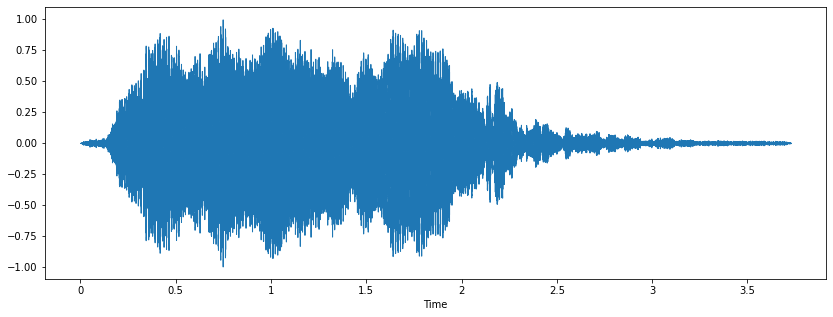

In [28]:
# Загрузим аудио файл с паровозным гудком
train_whistle, tw_sr = librosa.core.load("resources/train_whistle.wav")
print(f"Len is {len(train_whistle)} ( ). Sample rate is {tw_sr}")
player = ipd.Audio(train_whistle, rate=tw_sr)
ipd.display(player)
draw_waveform(train_whistle, sr=tw_sr)

Построим гудок паровоза в частотной области

Гудок паровоза в частотной области


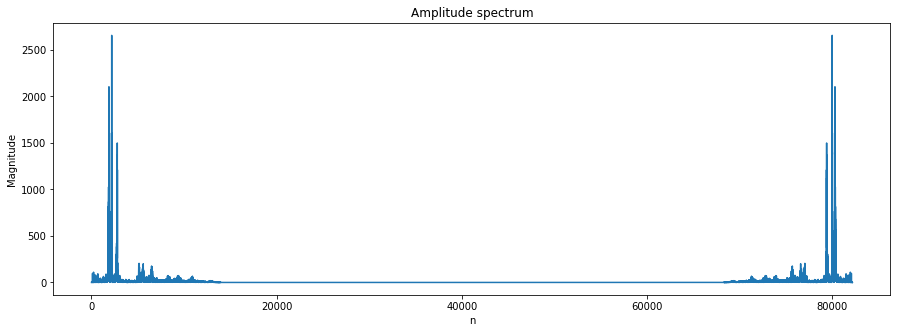

In [29]:
train_whistle_spec = scipy.fft.fft(train_whistle)
print("Гудок паровоза в частотной области")
draw_spec(train_whistle_spec, draw_p=False, figsize=(15,5))

# Задание 4 (2 балла)
Определите 3 основные гармоники паровозного гудка.

Ответ округлите до двух знаков после запятой.


Гудок паровоза в частотной области


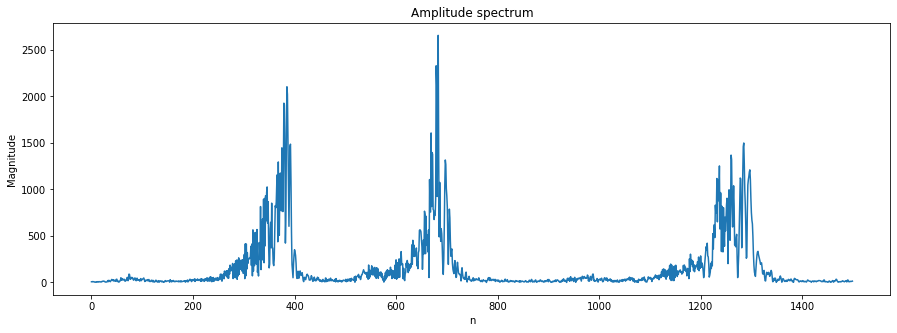

In [30]:
train_whistle_spec = get_amplitude_from_spec(train_whistle_spec)
print("Гудок паровоза в частотной области")
draw_spec(train_whistle_spec[1500:3000], draw_p=False, figsize=(15,5))

Амплитудный спектр

### 1 гармоника

In [31]:
freq1 = np.round((1500 + np.argmax(train_whistle_spec[1500:1900])) * tw_sr / len(train_whistle), 2)
freq1

505.8

### 2 гармоника

In [32]:
freq2 = np.round((2000 + np.argmax(train_whistle_spec[2000:2300])) * tw_sr / len(train_whistle), 2)
freq2

585.76

### 3 гармоника

In [33]:
freq3 = np.round((2700 + np.argmax(train_whistle_spec[2700:2850])) * tw_sr / len(train_whistle), 2)
freq3

747.3

### Тест

In [34]:
task_answer = [ freq1, freq2, freq3 ]

In [35]:
assert type(task_answer) == list or type(task_answer) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(task_answer)}"
assert len(task_answer) == 3, \
        f"Wrong len {len(task_answer)}."
assert (round(sum(task_answer)) == 1677 and round(np.var(task_answer)) == 1407) or \
        (abs(sum(task_answer)  - 1836) <= 3 and abs(np.var(task_answer) - 10153) <= 181), \
        f"Wrong freqs"
print("Correct!")       

Correct!


Теперь попробуйте сгенерировать сигнал, состоящий только из этих гармоник. Воспроизведите сигнал.

In [36]:
def generator(x, sample_rate = 44100, n = 44100):
    k = 2 * np.pi * np.array(x) / sample_rate
    res = np.zeros(n)
    for i in k:
        res += np.array(np.cos(i * np.arange(n)))

    return res

In [37]:
ipd.Audio(data=generator(task_answer, sample_rate = tw_sr, n = len(train_whistle)), rate=tw_sr)

# Анализ двухтонального многочастотного сигнала
Теперь расмотрим более сложный сигнал - [DTMF](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling). Такие сигналы используются для автоматизации набора телефонного номера. 

# Задание 5 (2 балла)
В данном аудио закодирован трехзначный номер. Используя таблицу с [wiki]:(https://ru.wikipedia.org/wiki/DTMF) определите, что за номер закодирован.


Визуализация

Len is 243102. Sample rate is 22050


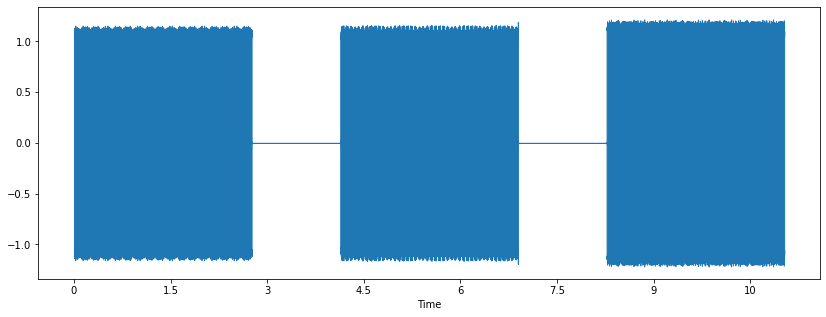

In [38]:
#dtmf.wav
dtmf, dtmf_sr = librosa.core.load("resources/dtmf.wav")
print(f"Len is {len(dtmf)}. Sample rate is {dtmf_sr}")
player = ipd.Audio(dtmf, rate=dtmf_sr)
ipd.display(player)
draw_waveform(dtmf, sr=dtmf_sr)

### 1 число

In [39]:
spec1 = scipy.fft.fft(dtmf[:60000])

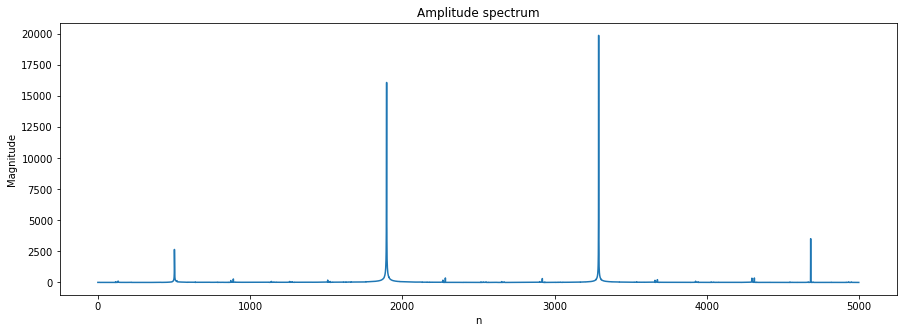

In [40]:
draw_spec(spec1[:5000], draw_p=False, figsize=(15,5))

In [41]:
freq1 = np.round((np.argmax(spec1[:2000])) * tw_sr / len(spec1))
freq2 = np.round((3000 + np.argmax(spec1[3000:3800])) * tw_sr / len(spec1))
freq1, freq2

(697.0, 1209.0)

Значит первое число -- 1

### 2 число

In [42]:
spec2 = scipy.fft.fft(dtmf[100000:150000])

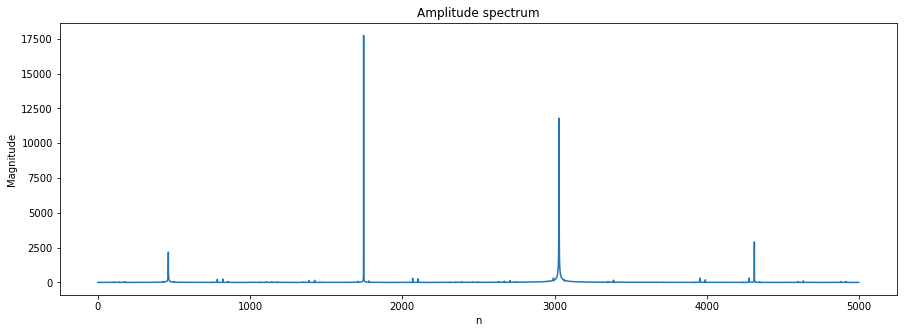

In [43]:
draw_spec(spec2[:5000], draw_p=False, figsize=(15,5))

In [44]:
freq1 = np.round((1500 + np.argmax(spec2[1500:2000])) * tw_sr / len(spec2))
freq2 = np.round((3000 + np.argmax(spec2[3000:3800])) * tw_sr / len(spec2))
freq1, freq2

(770.0, 1336.0)

Второе число -- 5

### 3 число

In [45]:
spec3 = scipy.fft.fft(dtmf[190000:240000])

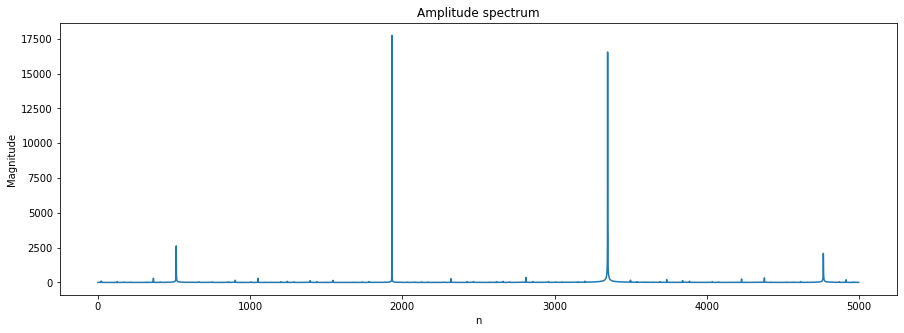

In [46]:
draw_spec(spec3[:5000], draw_p=False, figsize=(15,5))

In [47]:
freq1 = np.round((1800 + np.argmax(spec3[1800:2000])) * tw_sr / len(spec3))
freq2 = np.round((3000 + np.argmax(spec3[3000:3800])) * tw_sr / len(spec3))
freq1, freq2

(852.0, 1477.0)

И третье число -- 9

### Тест

In [48]:
phone_number = [1, 5, 9]

In [49]:
assert type(phone_number) == list or type(phone_number) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(phone_number)}"
assert len(phone_number) == 3, \
        f"Wrong len {len(phone_number)}."
assert round(np.mean(phone_number)) == 5 and round(np.var(phone_number)) == 11 , \
        f"Wrong number"
assert hashlib.md5(''.join(map(str, phone_number)).encode()).hexdigest() == "140f6969d5213fd0ece03148e62e461e", \
        f"Wrong hash. How did you pass mean/var test?"
print("Correct!")   

Correct!
